In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from reproject import reproject_interp
import os
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize
import requests
from astropy.table import Table
from astropy.nddata import CCDData, NDData
from photutils import psf, EPSFBuilder
from io import BytesIO
from PyZOGY.subtract import calculate_difference_image
from PyZOGY.image_class import ImageClass
import scipy
from image_subtraction import *
%matplotlib inline

# Read the science image

In [2]:
workdir = '/Users/griffin/imgsub/'
filename = os.path.join(workdir, 'PS17dbf.Science.5615_proc.fits')
scidata0 = read_with_datasec(filename)

INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


# Download the PS1 catalog

In [3]:
ccd_bbox = get_ccd_bbox(scidata0)
catalog = get_ps1_catalog(*ccd_bbox)

# Pretend to make the PSF for the science image
This is just to find the centroids of the stars so we can update the WCS in the next step

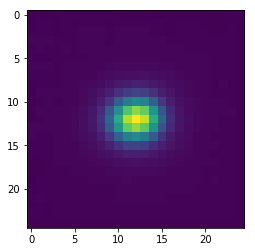

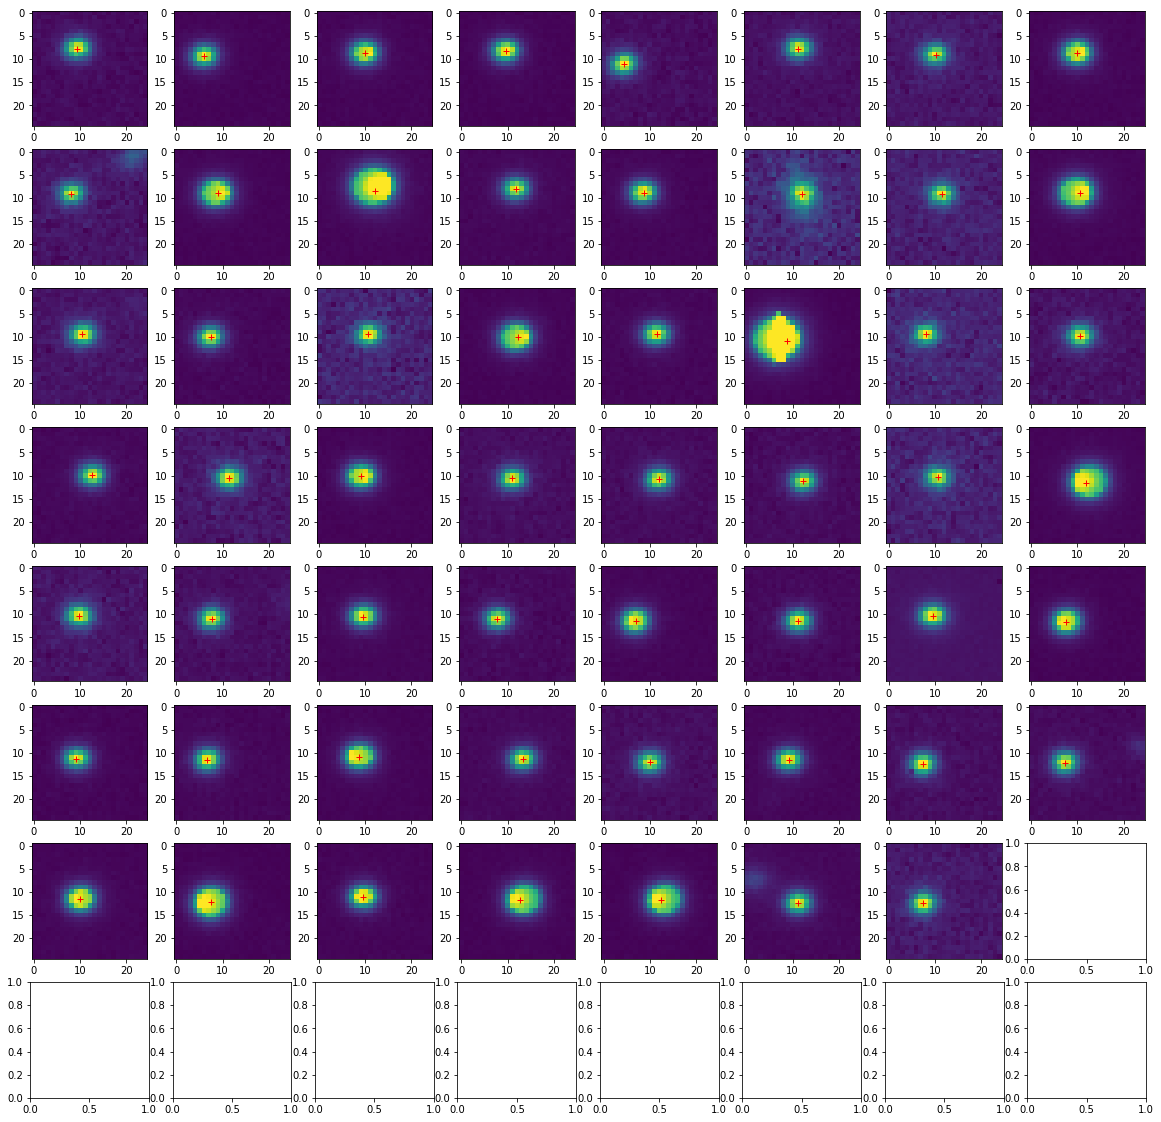

In [4]:
_, sci_stars = make_psf(scidata0, catalog, show=True)

# Update the WCS for the science image

In [5]:
scidata = scidata0.copy()
refine_wcs(scidata.wcs, sci_stars, catalog)

science_filename = os.path.join(workdir, 'science.fits')
scidata.write(science_filename, overwrite=True)

 orig_fun: 3.618614803007723
      fun: 0.7898621064350221
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00844895,  0.00409552, -0.00043709, -0.00064023])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 210
      nit: 14
   status: 0
  success: True
        x: array([ 1.15024743e-04, -8.67107539e-05, -2.08948328e-03,  9.99625384e-01])


# Actually make the PSF for the science image

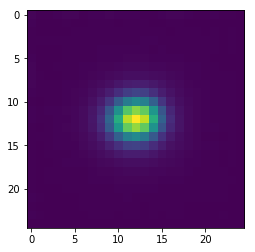

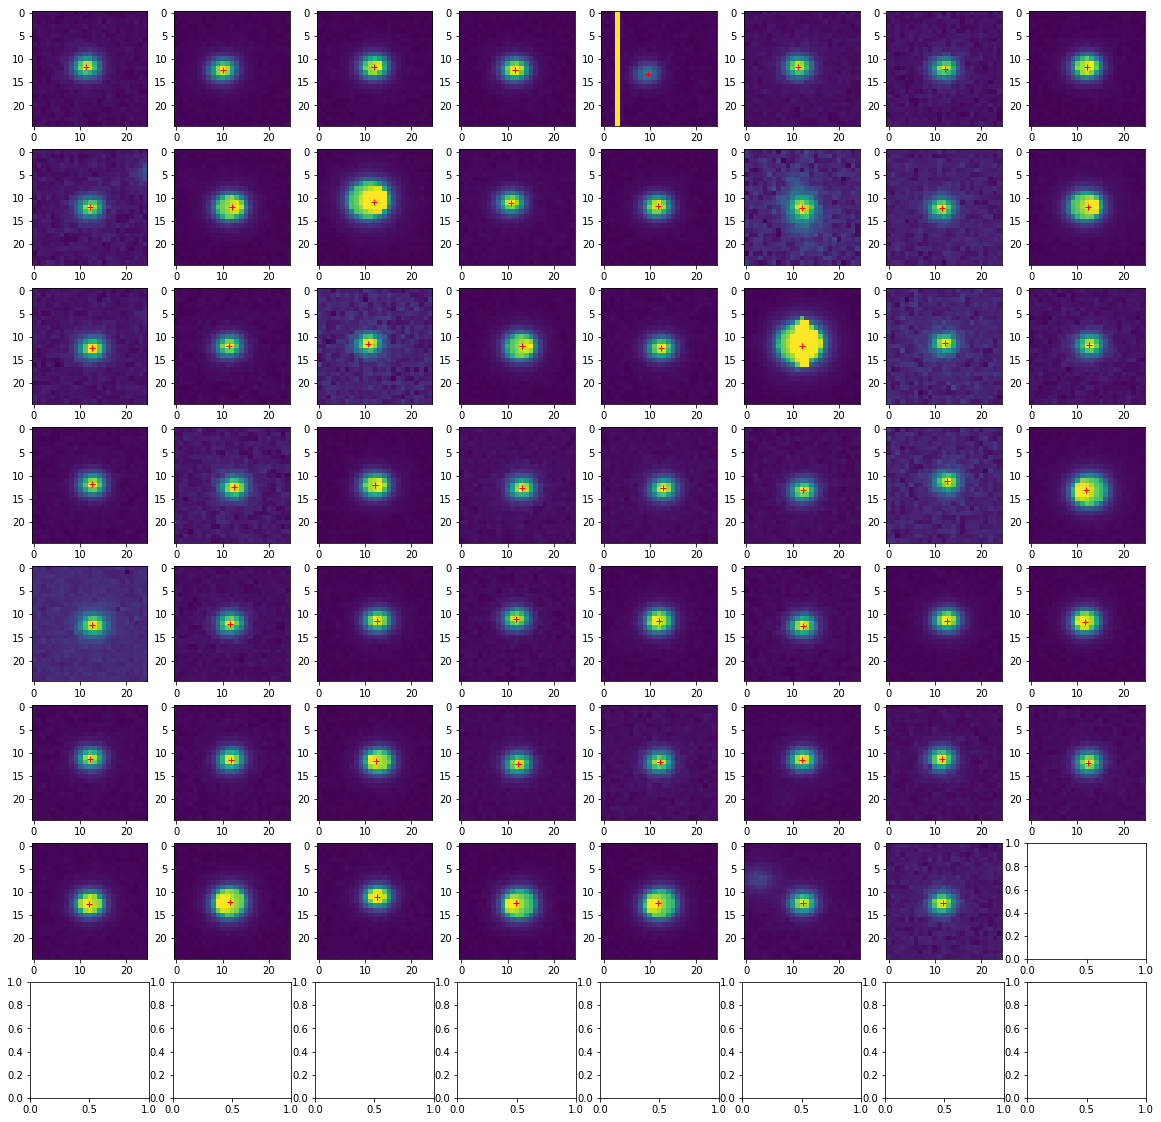

In [6]:
sci_psf, _ = make_psf(scidata, catalog, show=True)

# Download the reference images and update their WCS

In [7]:
refdatas = download_references(*ccd_bbox, scidata.meta['filter'][0], catalog=catalog)

downloading /rings.v3.skycell/1978/084/rings.v3.skycell.1978.084.stk.i.unconv.fits
 orig_fun: 1.2971057161059807 10) [0.1 s/iter]
      fun: 0.10818935205836677
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.11441813,  0.95979759, -0.15523993,  1.4456091 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 200
      nit: 23
   status: 0
  success: True
        x: array([-7.82521390e-05,  6.19543371e-05,  4.41476722e-05,  9.99898868e-01])
downloading /rings.v3.skycell/1978/085/rings.v3.skycell.1978.085.stk.i.unconv.fits
 orig_fun: 1.249765597388838ax 10) [0.1 s/iter]
      fun: 0.13603639180578772
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.63749669e-02, -3.90632029e+01, -3.20354661e+00, -1.34933766e+01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 160
      nit: 14
   status: 0
  success: True
        x: array([-1.32088118e-04, -1.55097095e-05,  7.44680781e-05,  9.99950245

# Reproject the reference image to match the science image

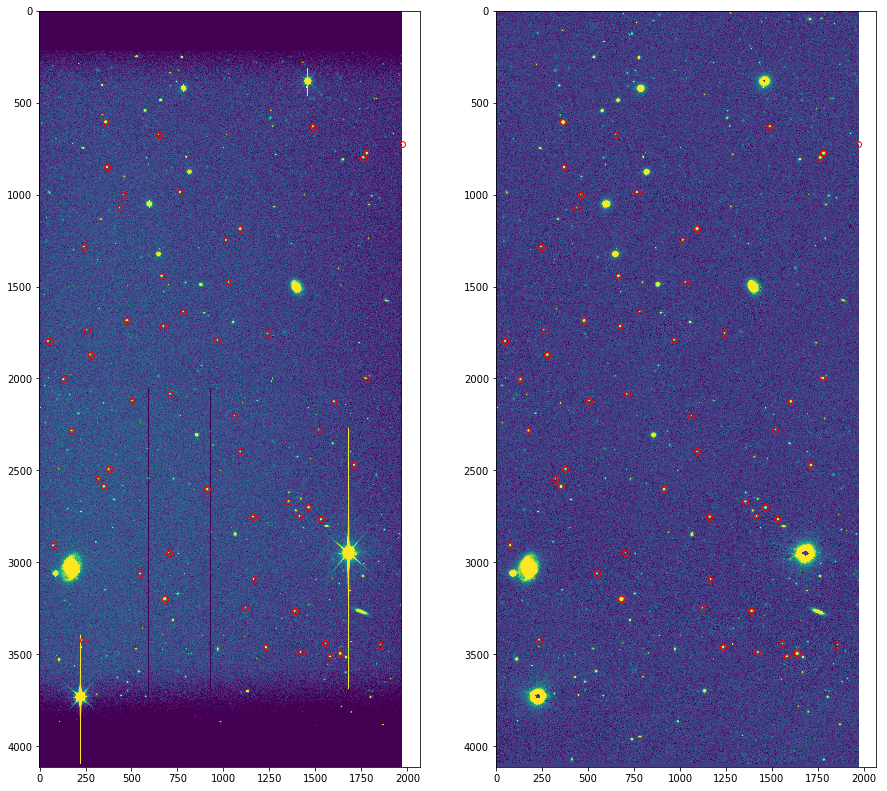

In [8]:
refdata = assemble_reference(refdatas, scidata.wcs, scidata.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
x, y = scidata.wcs.all_world2pix(catalog['raMean'], catalog['decMean'], 0.)

vmin, vmax = np.percentile(scidata.data, (15., 99.5))
ax1.imshow(scidata.data, vmin=vmin, vmax=vmax)
ax1.plot(x, y, marker='o', mec='r', mfc='none', ls='none')

norm = ImageNormalize(refdata.data, PercentileInterval(99.))
ax2.imshow(refdata.data, norm=norm)
ax2.plot(x, y, marker='o', mec='r', mfc='none', ls='none')

template_filename = os.path.join(workdir, 'template.fits')
refdata.write(template_filename, overwrite=True)

# Make the PSF for the reference image

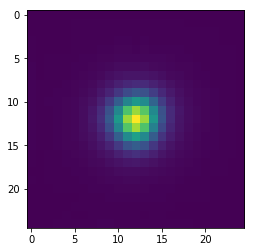

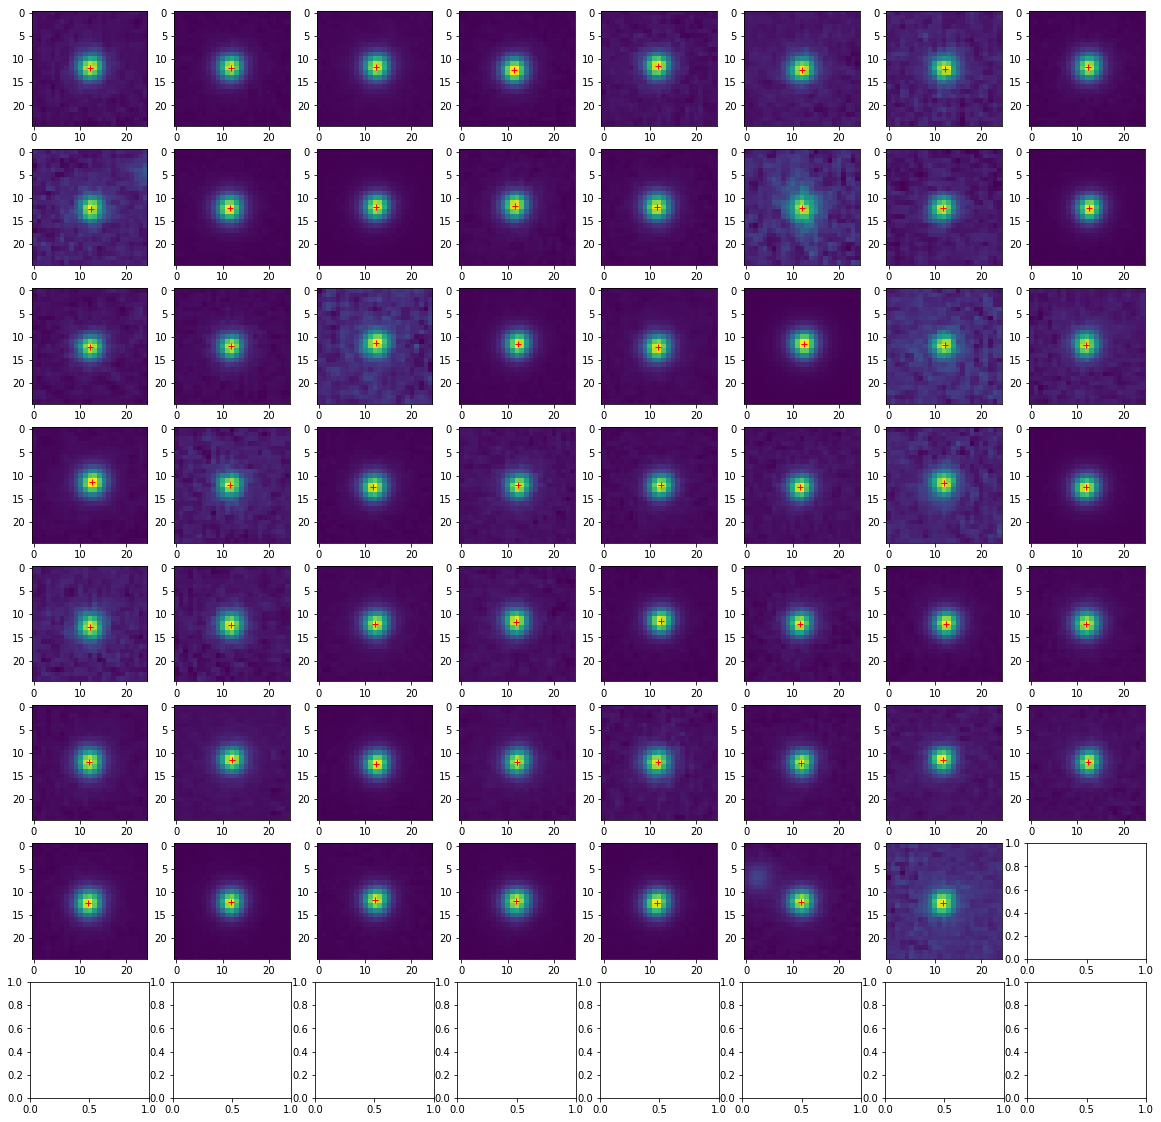

In [9]:
ref_psf, _ = make_psf(refdata, catalog, show=True)

# Subtract the images and view the result

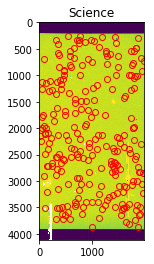

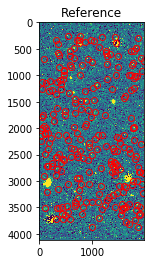

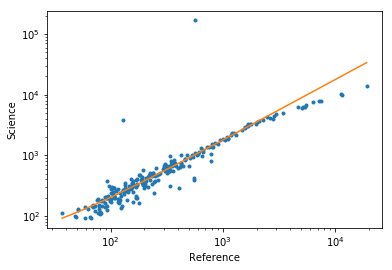

In [10]:
output_filename = os.path.join(workdir, 'diff.fits')
science = ImageClass(scidata.data, sci_psf.data, saturation=65565)
reference = ImageClass(refdata.data, ref_psf.data, refdata.mask)
difference = calculate_difference_image(science, reference, show=True, max_iterations=1)
fits.writeto(output_filename, difference, overwrite=True)

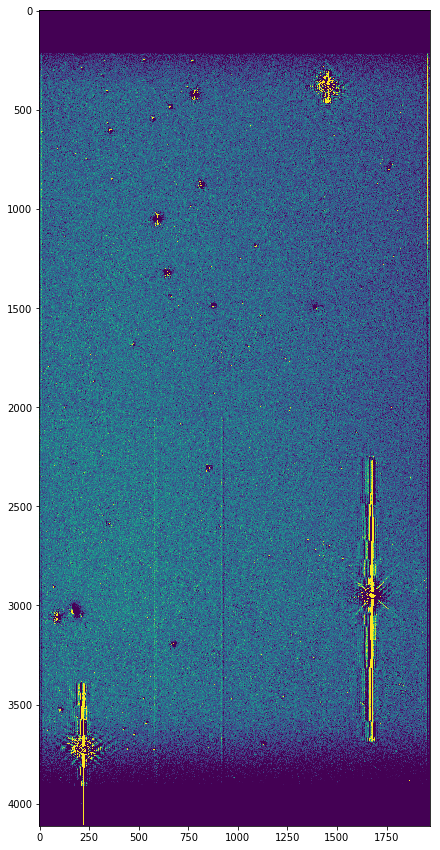

In [11]:
vmin, vmax = np.percentile(difference, (15., 99.5))
plt.figure(figsize=(7., 15.))
plt.imshow(difference, vmin=vmin, vmax=vmax)